<a href="https://colab.research.google.com/github/amansingh202/Machine-Learning/blob/main/Deep-learning/hw4_kumar_aman_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import matplotlib.pyplot as plt

class ag: # AutoGrad

    def abs(input):
        # FIX THIS FUNCTION
        output = ag.Scalar(abs(input.value), inputs=[input], op="abs")

        def _backward():
            if input.value > 0:
                input.grad += output.grad
            elif input.value < 0:
                input.grad -= output.grad
            else:
                input.grad += 0  # The gradient is zero at x = 0
            return None

        output._backward = _backward
        return output


    def log(input):
        output = ag.Scalar(math.log(input.value), inputs=[input], op="log")

        def _backward():
            input.grad += output.grad / input.value
            return None

        output._backward = _backward
        return output

    def exp(input):

        output = ag.Scalar(math.exp(input.value), inputs=[input], op="exp")

        def _backward():
            input.grad += output.grad * output.value
            return None

        output._backward = _backward
        return output

    def relu(input):
        output = ag.Scalar(max(0, input.value), inputs=[input], op="relu")

        def _backward():
            if input.value > 0:
                input.grad += output.grad
            return None

        output._backward = _backward
        return output

    class Scalar: # Scalars with grads
        def __init__(self,
                     value,
                     op="",
                     _backward= lambda : None,
                     inputs=[],
                     label=""):

            self.value = float(value)
            self.grad = 0.0

            self._backward = _backward
            self.inputs = inputs

            self.op = op
            self.label = label



        def backward(self):
            self.grad = 1.0

            topo_order = self.topological_sort()

            for node in reversed(topo_order):
                node._backward()

        def topological_sort(self):
            topo_order = []
            visited = set()

            def dfs(node):
                if node not in visited:
                    visited.add(node)
                    for input in node.inputs:
                        dfs(input)
                    topo_order.append(node)

            dfs(self)
            return topo_order


        def __add__(self, other):
            if not isinstance(other, ag.Scalar):
                other = ag.Scalar(other, label=f"{other}\nconst")

            output = ag.Scalar(self.value + other.value,
                               inputs=[self, other], op="add")

            def _backward():
                # pass
                self.grad += output.grad
                other.grad += output.grad

            output._backward = _backward
            return output


        def __mul__(self, other):
            if not isinstance(other, ag.Scalar):
                other = ag.Scalar(other, label=f"{other}\nconst")

            output = ag.Scalar(self.value * other.value,
                               inputs=[self, other], op="mul")

            def _backward():

                self.grad += other.value * output.grad
                other.grad += self.value * output.grad

                return None

            output._backward = _backward

            return output
        def __truediv__(self,other):
            return self*(other**(-1))

        def __neg__(self):
            output = ag.Scalar(-self.value, inputs=[self], op="neg")
            def _backward():
                self.grad -= output.grad
                return None
            output._backward = _backward
            return output
        def __sub__(self,other):
            return self + -other

        def __pow__(self, exponent): # exponent is just a python float
            output = ag.Scalar(self.value ** exponent, inputs=[self], op=f"pow({exponent})")

            def _backward():

                self.grad += (exponent * self.value**(exponent-1)) * output.grad
                return None

            output._backward = _backward
            return output

        def __repr__(self) -> str:
            if self.op == "":
                return self.label
            else:
                return self.label + "\n" + self.op


# Justification

<b>Forward Pass </b>: An ag.Scalar object is constructed to store the result once the absolute value is computed using Python's abs() function.

<b>Backward Pass </b>: The gradient is modified using the input value in the _backward() function; if the input is positive, the gradient stays the same (input.grad += output.grad). The gradient is inverted (input.grad -= output.grad) if the input is negative. The gradient is set to zero (input.grad += 0) if the input is zero. Now that the abs function has been fully built into your framework for automatic differentiation, it operates in a manner akin to the other functions you have used, such log, exp, etc.

# Visualization code not needed

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

def build_computation_graph(final_scalar):
    graph = nx.DiGraph()

    # DFS
    topo_order = final_scalar.topological_sort()

    # Count how many leaves
    # By convention, we hand-label our inputs
    # constants are labeled automatically
    labeled_nodes = [node for node in topo_order if node.label != "" and 'const' not in node.label]
    index = len(labeled_nodes) + 1

    for node in topo_order:
        if not node.label:  # If a node has no label, assign one
            node.label = f"z{index}"
            index += 1

        graph.add_node(node)
        if len(node.inputs) > 1:
            for idx, input_node in enumerate(node.inputs):
                graph.add_edge(input_node, node)
        elif len(node.inputs) == 1:
            graph.add_edge(node.inputs[0], node)

    return graph

def plot_computation_graph(graph, rad=0.2,node_size=2000):
    node_labels = {node: node.label + "\n" + node.op if node.op != "" else node.label for node in graph.nodes}

    # Assign layers to nodes for multipartite layout
    for layer, nodes in enumerate(nx.topological_generations(graph)):
        for node in nodes:
            graph.nodes[node]["layer"] = layer

    pos = nx.multipartite_layout(graph, subset_key="layer")

    node_colors = []
    node_edge_colors = []

    for node in graph.nodes:
        if "leaf" in node.label:
            node_colors.append('none')  # Input nodes: no fill
            node_edge_colors.append('black')
        elif "const" in node.label:
            node_colors.append('none')
            node_edge_colors.append('lightgray')
        else:
            node_colors.append('lightblue')
            node_edge_colors.append('none')

    curved_edges = []
    straight_edges = []

    for node in graph.nodes:
        incoming_edges = list(graph.in_edges(node))
        if len(incoming_edges) > 1:
            curved_edges.extend(incoming_edges)
        else:
            straight_edges.extend(incoming_edges)

    # Draw straight edges
    nx.draw(graph, pos, with_labels=False, edgelist=straight_edges,
            node_color=node_colors, edgecolors=node_edge_colors, node_size=node_size,
            font_size=10, font_weight='bold', arrows=True)

    # Draw curved edges with a specified curvature
    nx.draw(graph, pos, with_labels=False, edgelist=curved_edges,
            connectionstyle=f'arc3, rad={rad}', node_color=node_colors,
            edgecolors=node_edge_colors, node_size=node_size, font_size=10,
            font_weight='bold', arrows=True)

    nx.draw_networkx_labels(graph, pos=pos, labels=node_labels)


# Demo of the visulization code

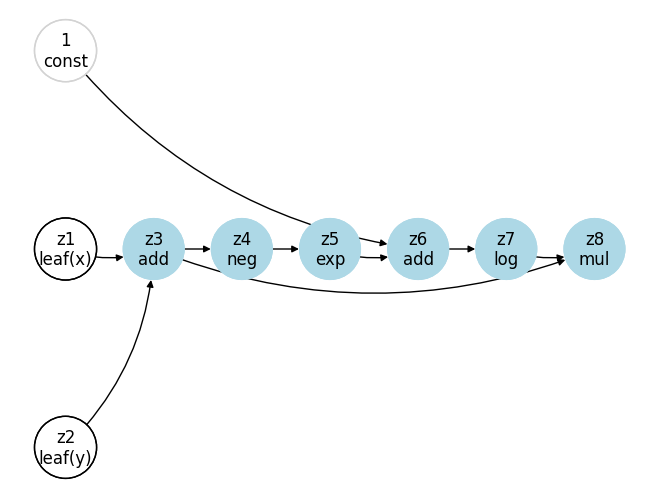

In [3]:


x = ag.Scalar(2.0, label="z1\nleaf(x)")  # z1
y = ag.Scalar(3.0, label="z2\nleaf(y)")  # z2

z1 = x
z2 = y

z3 = x+y

final_output = z3*ag.log(ag.exp(-(z3))+1)



computation_graph = build_computation_graph(final_output)
plot_computation_graph(computation_graph,0.2)

In [4]:
dfs_node_ordering = final_output.topological_sort()
[dfs_node_ordering[i].__repr__().replace("\n",":") for i in range(len(dfs_node_ordering))]

['z1:leaf(x)',
 'z2:leaf(y)',
 'z3:add',
 'z4:neg',
 'z5:exp',
 '1:const',
 'z6:add',
 'z7:log',
 'z8:mul']

# Problem 3 Gradient descent [10pts]




Consider the following extremely simple model: The model $f ( x ; \theta )$ has only a single real-valued parameter $\theta = b$ where $b \in \mathbb{R}$.
Regardless of the input,
the model always outputs $b$, i.e., $f(x ; \theta) = b$ for all $x$.
Suppose that we have $N=5$ samples. Moreover, the labels are
$$
y^{(1)} = 3, \quad y^{(2)} = 6 \quad y^{(3)} = 8.5 \quad y^{(4)} =11 \quad y^{(5)} = 16
$$
Using ag.Scalar, compute 10 iterations of (full batch) gradient descent on the empirical risk/loss function
$$
  \textstyle
  J(b) =
\frac{1}{N}\sum_{i=1}^{N}  | y^{(i)} - b|.
$$
Use $b = 0$ as initialization and $\eta = 5$ as the step size.


The loss derivative is
$$
  \frac{\partial}{\partial b}
| y - b|
=
\begin{cases}
  -1 &: \mbox{ if $b \le y$ } \\
  1 &: \mbox{ if $b > y$ }. \\
\end{cases}
$$
Note: the step size $\eta = 5$ is rather large and is not typical in actual usage.


## Your tasks
- implement the absolute value function in the `ag` class on line 7 in the first code block. Currently, it doesn't do anything.
- complete the following training loop

In [5]:
yvals = [3, 6, 8.5, 11, 16]
bval = 0
bvals = [bval]
eta = 5
y = [ag.Scalar(v) for v in yvals]
b = ag.Scalar(bval)

# ONLY MODIFY THE INTERIOR OF THE FOR LOOP
for t in range(10):
    pass

# ONLY MODIFY THE INTERIOR OF THE FOR LOOP

bvals


[0]

In [6]:
yvals = [3, 6, 8.5, 11, 16]  # Target values
bval = 0  # Initial value for b
bvals = [bval]  # List to store values of b
eta = 5  # Step size

# Convert target values to ag.Scalar
y = [ag.Scalar(v) for v in yvals]
b = ag.Scalar(bval)  # Initialize b as ag.Scalar

# Gradient descent for 10 iterations
for t in range(10):
    # Compute the total loss using the absolute value function
    losses = [ag.abs(ag.Scalar(y_i.value - b.value)) for y_i in y]
    loss = ag.Scalar(0)
    for l in losses:
        loss.value += l.value
    loss.value /= len(y)  # Average loss

    # Compute the gradient
    b.grad = 0
    for y_i in y:
        b.grad += -1 if y_i.value > b.value else 1
    b.grad /= len(y)

    # Update the parameter b using gradient descent
    b.value -= eta * b.grad

    # Store the updated value of b
    bvals.append(b.value)

# Output the list of b values
print(bvals)

[0, 5.0, 8.0, 9.0, 8.0, 9.0, 8.0, 9.0, 8.0, 9.0, 8.0]


# Expected output


In [7]:
# bvals
# [0, 5.0, 8.0, 9.0, 8.0, 9.0, 8.0, 9.0, 8.0, 9.0, 8.0]

# Problem 4 Transformer [bonus 20pts]


Calculate using `ag.Scalar` the following: `dJdw3` `dJdW2` and `dJdW1` from homework 3. Use the configuration/data below.

`X_raw` corresponds to `X` from homework 3.

`y_raw` corresponds to `y` from homework 3.

And so on.

Do not change the following block.

In [8]:
n_context = 4
n_features = 3
n_samples = 5
n_reduced = 2

X_raw = [[[-0.707, -0.707, 1.0],
          [0.963, -0.268, 1.0],
          [0.391, 0.92, -1.0],
          [0.899, 0.437, -1.0]],
         [[0.327, -0.945, 1.0],
          [0.3, -0.954, -1.0],
          [-0.485, -0.874, -1.0],
          [-0.694, 0.72, 1.0]],
         [[-0.309, 0.951, -1.0],
          [-0.951, 0.31, 1.0],
          [-0.9, -0.437, 1.0],
          [-0.013, -1.0, -1.0]],
         [[0.829, -0.559, -1.0],
          [-0.856, 0.518, 1.0],
          [-0.2, -0.98, -1.0],
          [-0.842, -0.539, 1.0]],
         [[-0.938, -0.346, 1.0],
          [-0.742, 0.67, -1.0],
          [0.742, 0.67, -1.0],
          [0.322, 0.947, -1.0]]]
y_raw = [-1.0, -1.0, 1.0, 1.0, -1.0]

W1_raw = [[0.74, 0.529], [-0.589, 0.189], [-0.759, -0.933]] # n_features by n_reduced
W2_raw = [[0.504, 0.651], [-0.319, -0.848], [0.606, -2.018]] # n_features by n_reduced
w3_raw = [2.707, 0.628, 0.908] # n_features

## Expected output

In [9]:
# output of forward
# [ 1.6528977 , -0.50304305, -1.54629904, -1.18000691,  0.74528666]

# dJdw3
# [ 0.29006619,  0.31213455, -0.22591685]

# dJdW2
# [[ 0.05486582,  0.13401244],
#  [-0.01348159, -0.00905539],
#  [ 0.01421121,  0.01478831]]


# dJdW1
# [[ 0.02673784,  0.01136829],
#  [ 0.04348804,  0.05114747],
#  [-0.06112444, -0.05294486]]

## Your code

In [10]:
def scalar_sum(scalars):
    return ag.Scalar(sum(s.value for s in scalars))

In [11]:
def compute_dJdW1(X, y, theta):
    W1, W2, w3 = theta['W1'], theta['W2'], theta['w3']
    n_samples = len(X)
    n_timesteps = len(X[0])
    n_features = len(X[0][0])
    n_reduced = len(W1[0])

    # Compute query and Key for all samples
    query = [[scalar_sum(X[i][-1][j] * W1[j][k] for j in range(n_features)) for k in range(n_reduced)] for i in range(n_samples)]
    Key = [[[scalar_sum(X[i][t][j] * W2[j][k] for j in range(n_features)) for k in range(n_reduced)] for t in range(n_timesteps)] for i in range(n_samples)]

    # Compute attention
    attention = [[scalar_sum(Key[i][t][k] * query[i][k] for k in range(n_reduced)) for t in range(n_timesteps)] for i in range(n_samples)]

    # Compute exp_key_query
    exp_key_query = [[ag.Scalar(np.exp(attention[i][t].value)) for t in range(n_timesteps)] for i in range(n_samples)]

    # Compute softmax
    softmaxKq = [[exp_key_query[i][t] * (ag.Scalar(1) / scalar_sum(exp_key_query[i])) for t in range(n_timesteps)] for i in range(n_samples)]

    # Compute z
    z = [scalar_sum(scalar_sum(softmaxKq[i][t] * X[i][t][j] for t in range(n_timesteps)) * w3[j] for j in range(n_features)) for i in range(n_samples)]

    # Compute loss derivative
    loss_derivative = [y[i] * (ag.Scalar(-np.exp(-y[i].value * z[i].value)) / (ag.Scalar(1) + ag.Scalar(np.exp(-y[i].value * z[i].value)))) for i in range(n_samples)]

    # Compute derivative of softmax output
    softmaxDer = [[[softmaxKq[i][t1] * (ag.Scalar(1) if t1 == t2 else ag.Scalar(0)) - softmaxKq[i][t1] * softmaxKq[i][t2] for t2 in range(n_timesteps)] for t1 in range(n_timesteps)] for i in range(n_samples)]

    # Compute intermediate results
    X_w3 = [[scalar_sum(X[i][t][j] * w3[j] for j in range(n_features)) for t in range(n_timesteps)] for i in range(n_samples)]

    # Modified ir1 computation
    ir1 = [[scalar_sum(scalar_sum(Key[i][t1][k] * softmaxDer[i][t1][t2] for t1 in range(n_timesteps)) * X_w3[i][t2] for t2 in range(n_timesteps)) for k in range(n_reduced)] for i in range(n_samples)]

    ir2 = [X[i][-1] for i in range(n_samples)]

    # Compute the final result
    result = [[scalar_sum(ir2[i][j] * ir1[i][k] * loss_derivative[i] for i in range(n_samples)) for k in range(n_reduced)] for j in range(n_features)]

    # Normalize the results
    dJdW1 = [[result[j][k] * (ag.Scalar(1) / ag.Scalar(n_samples)) for k in range(n_reduced)] for j in range(n_features)]

    print("\nFinal dJdW1 result:")
    for row in dJdW1:
        print([scalar.value for scalar in row])

    return dJdW1

In [12]:
import numpy as np
# Convert raw data to ag.Scalar objects
X = [[[ag.Scalar(val) for val in timestep] for timestep in sample] for sample in X_raw]
y = [ag.Scalar(val) for val in y_raw]
W1 = [[ag.Scalar(val) for val in row] for row in W1_raw]
W2 = [[ag.Scalar(val) for val in row] for row in W2_raw]
w3 = [ag.Scalar(val) for val in w3_raw]

theta = {'W1': W1, 'W2': W2, 'w3': w3}

# Call the function
result = compute_dJdW1(X, y, theta)


Final dJdW1 result:
[0.026737842820472923, 0.0113682946765902]
[0.043488040049078316, 0.05114747020150523]
[-0.06112443715812871, -0.05294485874898052]


In [15]:
import numpy as np
import autograd.numpy as agnp
from autograd import grad


def compute_dJdW3_ag_scalar(X, y, W1, W2, w3):
    query = agnp.dot(X[:, -1, :], W1)
    Key = agnp.dot(X, W2)

    dot_product = agnp.sum(Key * query[:, agnp.newaxis, :], axis=2)
    exp_key_value = agnp.exp(dot_product)

    softmax_key_value = exp_key_value / agnp.sum(exp_key_value, axis=1)[:, agnp.newaxis]

    X_w3 = agnp.dot(X, w3)
    zi = agnp.sum(softmax_key_value * X_w3, axis=1)
    softmax_X = agnp.sum(softmax_key_value[:, :, agnp.newaxis] * X, axis=1)

    loss = agnp.mean(agnp.log(1 + agnp.exp(-y * zi)))
    return loss

# Set up the input data
n_context = 4
n_features = 3
n_samples = 5
n_reduced = 2

# Convert to numpy arrays
X = np.array(X_raw)
y = np.array(y_raw)
W1 = np.array(W1_raw)
W2 = np.array(W2_raw)
w3 = np.array(w3_raw)

# Create theta dictionary for the original function
theta = {'W1': W1, 'W2': W2, 'w3': w3}



# Use autograd to compute the gradient
result_ag_scalar = grad_ag_scalar(X, y, W1, W2, w3)

# Compare results

print("\nAutograd result:")
print(result_ag_scalar)



Autograd result:
[ 0.29006619  0.31213455 -0.22591685]
